In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from numpy.random import default_rng
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import scipy
import matplotlib.pyplot as plt
%matplotlib inline

## PART I

1) Load the data from data/data.txt in your HW6 directory

In [2]:
data=np.loadtxt('data/data.txt')
nobs=data.size

2) Using the first 500 observations (training sample) and the ARIMA function of statsmodels, estimate ARMA(p,q) models for all combinations of AR and MA lags of between 0 and 4, with and without a constant.

In [3]:
train_sample=500

ic_result=np.empty((0,4))

for p in range(0,5):
    for q in range(0,5):
        for t in {'n','c'}:
            arma_model=ARIMA(data[0:500], trend=t, order=(p, 0, q))
            results=arma_model.fit()
            ic_result=np.append(ic_result, [[f'p={p}, q={q}, const={t}', results.aic, results.bic, results.resid]], axis=0)

3) Find out and report which specifications minimize the AIC and the BIC criteria. 

In [4]:
aic_min=ic_result[np.argmin(ic_result[:,1]), 0]
bic_min=ic_result[np.argmin(ic_result[:,2]), 0]

print(f'The specification that minimizes the AIC is {aic_min} and the one that minimizes the BIC is {bic_min}.')

The specification that minimizes the AIC is p=4, q=0, const=c and the one that minimizes the BIC is p=1, q=0, const=c.


4) Plot the ACFs and PACFs of the residuals of those specifications in a 2x2 plot with titles indicating the order and whether a constant is included.

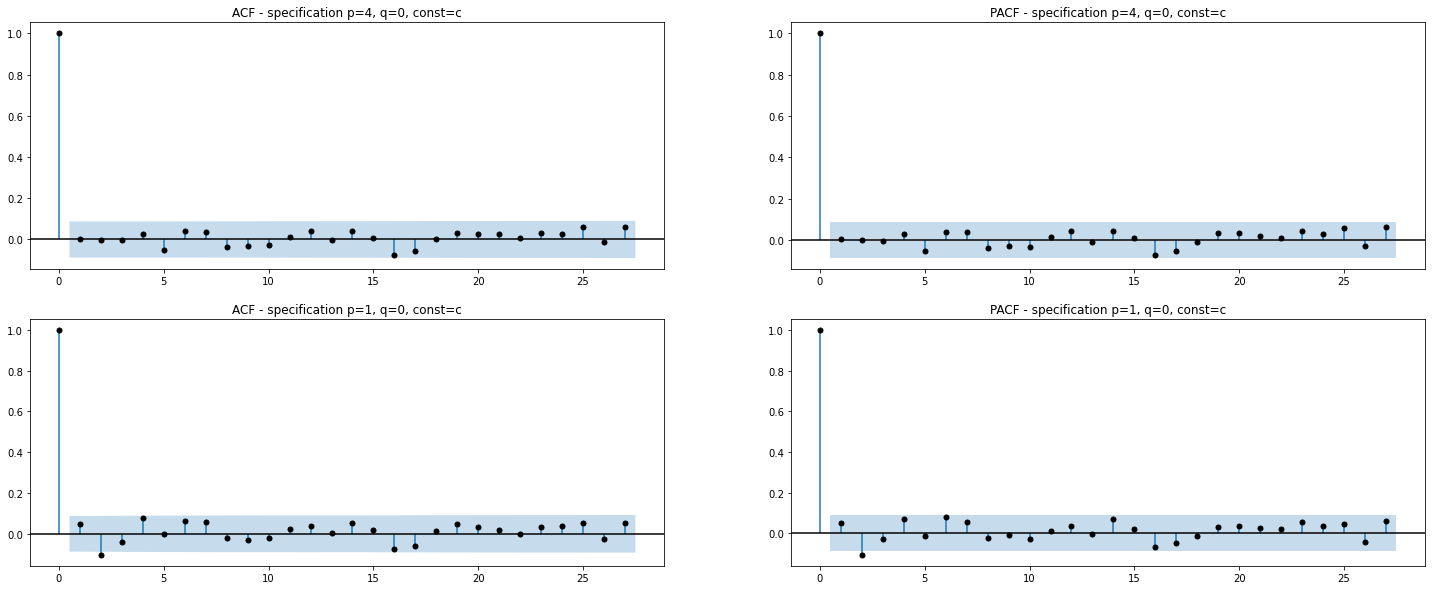

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(25,10))

plot00=sm.graphics.tsa.plot_acf(ic_result[np.argmin(ic_result[:,1]), 3], ax=axs[0, 0], title=f'ACF - specification {aic_min}', color='black')
plot01=sm.graphics.tsa.plot_pacf(ic_result[np.argmin(ic_result[:,1]), 3], ax=axs[0, 1], title=f'PACF - specification {aic_min}', color='black')
plot10=sm.graphics.tsa.plot_acf(ic_result[np.argmin(ic_result[:,2]), 3], ax=axs[1, 0], title=f'ACF - specification {bic_min}', color='black')
plot11=sm.graphics.tsa.plot_pacf(ic_result[np.argmin(ic_result[:,2]), 3], ax=axs[1, 1], title=f'PACF - specification {bic_min}', color='black')

plt.savefig(f"ACF&PACF_residuals", dpi=300)

## Part II

Using the selected model or models from Part 1, make and store forecasts for 1 and 2 periods ahead.

In [6]:
#Changing from data array to dataframe
dataframe= pd.DataFrame(data)
dataframe

,0
0,1.920662
1,3.763282
2,3.300622
3,0.280529
4,0.575593
...,...
595,2.182119
596,1.506874
597,0.536500
598,2.027510


In [7]:
#Selected model - AIC
arma_model_1=ARIMA(dataframe[0:500], trend='c', order=(4, 0, 0))
resid_1=arma_model_1.fit()

#Selected model - BIC
arma_model_1=ARIMA(dataframe[0:500], trend='c', order=(1, 0, 0))
resid_2=arma_model_1.fit()

In [8]:
#forecasting 2 periods ahead
initial_fcst_aic=resid_1.forecast(steps=2)
initial_fcst_bic=resid_2.forecast(steps=2)

In addition, construct 1 and 2 steps ahead forecasts using the following naive models: (1) the last data point used for estimation, (2) the average value of the sample used for estimation. 

In [9]:
#https://otexts.com/fpp2/simple-methods.html

#regrading the forecast with the last data point used for estimation
aic_fcst_naive_last=pd.DataFrame([dataframe.iloc[train_sample-1], dataframe.iloc[train_sample-1]])
bic_fcst_naive_last=pd.DataFrame([dataframe.iloc[train_sample-1], dataframe.iloc[train_sample-1]]) 

#regrading the forecast with the average of the sample
aic_fcst_naive_mean=pd.DataFrame([dataframe.iloc[0:train_sample].mean(), dataframe.iloc[0:train_sample].mean()])
bic_fcst_naive_mean=pd.DataFrame([dataframe.iloc[0:train_sample].mean(), dataframe.iloc[0:train_sample].mean()]) 


Adding one observation at a time from the part of the sample which was not used during the estimation in Part 1 (testing sample), re-estimate each ARMA model and produce and store forecasts for 1 and 2 periods ahead. 

In [10]:
#Dictionary that will save the errors
rmse_2period = {
}

In [11]:
def genforecast(nforecasts,arima_order,arima_trend,data,tsize):
# Setup forecasts
    nobs=len(data)
    forecasts = {}
    init_training_endog = dataframe.iloc[:tsize]
    model=ARIMA(init_training_endog, trend=arima_trend, order=arima_order)
    modelresults=model.fit()

# Save initial forecast
    forecasts[init_training_endog.index[-1]] = modelresults.forecast(steps=nforecasts)
# Step through the rest of the sample
    for t in range(tsize, nobs-nforecasts):
    # Update the results by appending the next observation
        updated_data = dataframe.iloc[t:t+1]
        modelresults = modelresults.append(updated_data, refit=True)

    # Save the new set of forecasts
        forecasts[updated_data.index[0]] = modelresults.forecast(steps=nforecasts)

# Combine all forecasts into a dataframe
    forecasts=pd.concat(forecasts, axis=1)
    
    return forecasts

In [12]:
fcst_arima_aic_2period=genforecast(2, (4,0,0), 'c', dataframe, train_sample)
fcst_arima_bic_2period=genforecast(2, (1,0,0), 'c', dataframe, train_sample)


In [13]:
#creating a function that computes the errors and the MSE from all the forecasts displayed in the form of matrix (as the previous)
def comprmse(df):
    fcst_errors = {}
    for c in df.columns:
        fcst_errors[c] = dataframe.iloc[train_sample:, 0] - df.loc[:,c]

    fcst_errors = pd.DataFrame.from_dict(fcst_errors)    

    def flatten(column):
        return column.dropna().reset_index(drop=True)

    flattened = fcst_errors.apply(flatten)
    flattened.index = (flattened.index + 1).rename('horizon')
    flattened.T.head()

    fcst_errors = flattened.T.dropna().values.flatten()

    RMSE = (fcst_errors**2).mean()**0.5

    return RMSE

In [14]:
rmse_2period["Arma, adding one obs at a time, order (4,0,0), with const"]=comprmse(fcst_arima_aic_2period)
rmse_2period["Arma, adding one obs at a time, order (1,0,0), with const"]=comprmse(fcst_arima_bic_2period)

Do the same with the two naive models, taking into account the added observat

In [15]:
nobs=len(dataframe)
fcsts_last_2p = {}
init_training_endog = dataframe.iloc[:train_sample]

# Save initial forecast
fcsts_last_2p[init_training_endog.index[-1]] = pd.DataFrame([dataframe.iloc[train_sample-1], dataframe.iloc[train_sample-1]], index=[500,501])

# Step through the rest of the sample
for t in range(train_sample, nobs-2):
    # Update the results by appending the next observation
    updated_data = pd.DataFrame([dataframe.iloc[t], dataframe.iloc[t]], index=[t+1, t+2])
    
    # Save the new set of forecasts
    fcsts_last_2p[updated_data.index[0]-1] = updated_data
    
# Combine all forecasts into a dataframe
fcsts_last_2p=pd.concat(fcsts_last_2p, axis=1)

In [16]:
rmse_2period["Naive, last data point, adding one obs at a time, order (4,0,0) or (1,0,0), with const"]=comprmse(fcsts_last_2p)

Repeat until there are only two observations left in the testing sample. 

In [17]:
nobs=len(dataframe)
fcsts_mean_2p = {}
init_training_endog = dataframe.iloc[:train_sample]

# Save initial forecast
fcsts_mean_2p[init_training_endog.index[-1]] = pd.DataFrame([init_training_endog.mean(),init_training_endog.mean()], index=[500,501])

# Step through the rest of the sample
for t in range(train_sample, nobs-2):
    # Update the results by appending the next observation
    updated_data = pd.DataFrame([dataframe.iloc[:t+1].mean(), dataframe.iloc[:t+1].mean()], index=[t+1, t+2])

    # Save the new set of forecasts
    fcsts_mean_2p[updated_data.index[0]-1] = updated_data
    
# Combine all forecasts into a dataframe
fcsts_mean_2p=pd.concat(fcsts_mean_2p, axis=1)

In [18]:
rmse_2period["Naive, training sample average, adding one obs at a time, order (4,0,0) or (1,0,0), with const"]=comprmse(fcsts_mean_2p)

Construct the forecast errors and compute the root mean squared errors for each horizon and each model. Which model/models has the lowest errors?

In [19]:
min_2period = min(rmse_2period, key=rmse_2period.get)

In [20]:
print(f'Among the all the models the model that minimizes the root mean squared errors is: {min_2period}')

Among the all the models the model that minimizes the root mean squared errors is: Arma, adding one obs at a time, order (1,0,0), with const
